# Python Implementation of the OFC Reservoir Network

## Paradigm Model
Zhang, et. al. published in early 2018 [A neural network model for the orbitofrontal cortex and task space acquisition during reinforcement learning](https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1005925&type=printable).  Here, the authors implemented a reservoir neural network whose learning behaviour is similar to that of mice during all learning phases, including Reversal Naive and Reversal Expert.

This work takes both inspiration from their work and is motivated by engineering and biological questions spurred by the model's implementation and alleged success.  I have included the first figure from their paper which serves as a good overview of their work. <br>

![alt text](https://journals.plos.org/ploscompbiol/article/figure/image?size=medium&id=info:doi/10.1371/journal.pcbi.1005925.g001)

Their original MATLAB code is also available in the a public [GitHub repository](https://github.com/tyangLab/ReservoirNet_OFC_TaskState).


## Mathematics
Below are the mathematical formulations used directly in the reservoir neural network model.  The network has N nodes whose activation value $x$ is represented by 
\begin{align}
\ \tau\frac{dx}{dt}= -x_i + g \sum_{j=1}^N w_{ij} y_j + w_i^{(i)}I + \sigma_{noise}dW_i \\
x(t + 1) = x(t) + \dot{x}(t)\Delta t
\end{align}

Where $dW_i$ stands for white noise sampled from a uniform distribution [0, 1] and $\sigma_{noise}$ is its variance.  $y_i$ is the firing rate of neuron $i$, relative to a $y_{min}=0$, $y_{max}=1$ and baseline firing rate $y_0 = 0.1$.  It is determined by the following piecewise function:
\begin{align}
y=   \left\{
\begin{array}{ll}
      y_0 + y_0 tanh(x/y_0) & x \leq 0   \\
      y_0 + (y_{max} - y_0)*tanh(\frac{x}{y_{max}- y_0}) & x > 0 \\
\end{array} 
\right.
\end{align}

The contributions of each node are then summed to $v_k$.   $p_k$ then is determined by performing a softmax on $v_k$.  $p_k$ then becomes the expected reward $E[r_k]$<br>
\begin{align}
v_k = \sum_{i=1}^N w_{out} * y_i \\
p_k = E[r_k] = \frac{e^{-\beta v_k}}{\sum_i e^{-\beta v_i}}
\end{align}

The final output elements $z_k$ is either 1 with probability $p_k$ or 0 with probability $1 - p_k$  The weighted random choice in this experiment is between two actions $a_k$:  $a_1=<0, 1>$  and $a_2=<1,0>$, where $z_1 = 1$ means $a_1$ was chose, and $z_2=1$ means $a_2$ was chosen. 


The weights on the output layer ($w_{out}$) are the only ones that are plastic.  These are only updated on the same timestep that the reward $r$ is administered because the mice do not receive any information nor feedback when they refuse to lick, regardless of the texture presented.  The update is relative to the particular decision taken $z_k$ and whether a given neuron $y_i$ had a firing rate greater than the threshold $y_{th}$.
\begin{align}
\Delta w_{out} = \eta (r - E[r]) (y_i - y_{th}) z_k \\
w_{out}(n + 1) = w_{out}(n) + \Delta w_{out} \\
\end{align}
Finally, the weights are normalized after each update:
\begin{align}
w_{out}(n) = \frac{w_{out}(n)}{\sqrt{\sum_{i=1}^N ||w_{out}(n)||^2}}
\end{align}

## Implementation

Below I have directly implemented the formulated model as stated in the paper and run a few trials using their parameter specifications.

In [1]:
# Imports.
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
import seaborn as sns
sns.set()

In [2]:
# Experimental parameters.

num_trials = 1000 # Original number: 1000
StopTrainingTrials = 5000
numReversed = 100
reinforcedSchedule = 1 # determined or prob
withRF = 1  # reward feedback
numMod = 1
detail = 0
REinitial = 1
simutan= 1
blocking = 0 # 0:no block, 1: random block,  2:A block,  3: AR block 

# set the time
dt = 0.001
start = 0.2    # upon time of stimulus
sdur = 0.5    # duration of the stimulus
inter = 0   # interval between stimulus and reward
rdur = 0.5    # duration of reward input
delay = 0.2   # delay before decision
intertrial = 0
tau = 0.1 # time constant 

In [3]:
# Model parameters from OFC paper for the reversal learning task

reservoir_network_params = {
    'tau'         : 0.1,         # 100ms.
    'dt'          : 0.001,       # 1ms.
    'network gain': 2,           # g
    'training threshold': 0.2,   # y_th
    'temp parameter'    : 4,     # B (beta)
    'learning rate'     : 0.001, # n (eta)
    'max firing rate'   : 1,     # y_max
    'base firing rate'  : 0.1,   # y_0
    'noise gain'  : 0.01,        # sigma_noise
    'initial noise gain': 0.01,  # sigma_ini
    'input gain'  : 4,           # g_IR        gain input -> reservoir
    'input prob'  : 0.2,         # p_IR        prob input -> reservoir
    'hidden layer prob' : 0.1,   # p           Probability of connection in hidden layer
}

In [4]:
# Helper functions.

def sigmoid(x, x_0=1):
    return 1/(1 + np.exp(x/x_0))

def softmax(x, beta):
    e = np.exp(-beta * x)
    return e / e.sum()
  
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
  
def gaussian(mu,s2):
    return np.exp(-mu**2/2/s2) / np.sqrt(2 * np.pi * s2)

def smooth(x1, x2, y1, s2):
    N2 = len(x2)
    y2 = np.zeros(N2)

    # Check that the new data range does not exceed the old one
    rangeX1 = [np.min(x1), np.max(x1)]
    rangeX2 = [np.min(x2), np.max(x2)]

    for i2 in range(x2.size):
        w_ker = gaussian(x2[i2] - x1, s2)
        w_ker /= np.sum(w_ker)
        y2[i2] = w_ker.dot(y1)

    return y2

In [5]:
# Implementation of the OFC paper reservoir network.

class OFCPaperNeuralNetwork(object):
    def __init__(self, params, nodes=500, input_dim=2, output_dim=2, reward_dim=1):
        self.output_dim = output_dim
        self.params = params.copy()
        self.init_input_weights(input_dim + reward_dim, nodes)
        self.init_hidden_weights(nodes)
        self.init_neurons(nodes)
        self.init_output_weights(nodes, output_dim)
        self.exp_r = np.zeros(output_dim)
        self.z = np.zeros(output_dim)

    def init_input_weights(self, input_dim, nodes):
        std_dev = self.params['input gain']  # The paper uses a variance of g_IR^2
        w_input = np.random.normal(loc=0.0, scale=std_dev, size=(input_dim, nodes))
        p_IR = self.params['input prob']
        indices = np.random.choice([0, 1], size=w_input.shape, p=[1 - p_IR, p_IR]) 
        self.w_input = np.multiply(w_input, indices)

    def init_hidden_weights(self, nodes):
        g = self.params['initial noise gain']
        p = self.params['hidden layer prob']
        std_dev = g / np.sqrt(p * nodes) # The paper uses a variance of g^2/(p*N)
        W = np.random.normal(loc=0.0, scale=std_dev, size=(nodes, nodes))
        indices = np.random.choice([0, 1], size=W.shape, p=[1 - p, p]) 
        self.hidden_weights = np.multiply(W, indices)

    def init_neurons(self, nodes):
        std_dev = self.params['initial noise gain'] # The paper uses a variance of sigma_ini^2
        x = np.random.normal(loc=0.0, scale=std_dev, size=nodes)
        y = np.ones(nodes) * self.params['base firing rate']
        self.x = x
        self.y = y

    def init_output_weights(self, nodes, output_dim):
        W = np.random.normal(loc=0.0, scale=1, size=(nodes, output_dim))
        # According to the paper: normalize according to the squared sum of the weights for each output node.
        W = W/np.sqrt(np.square(W).sum(axis=0))
        self.output_weights = W
    
    def step(self, I=0):
        if np.array_equal(I, 0):
            I = np.zeros(self.w_input.shape[0])

        tau = self.params['tau']
        dt = self.params['dt']
        g = self.params['network gain']
        sigma_noise = self.params['noise gain']
        y_0 = self.params['base firing rate']
        y_max = self.params['max firing rate']
        
        white_noise = np.random.randint(0, high=(1 + 1), size=self.x.size)
        
        dx_dt = 1/tau * (-self.x + g * np.dot(self.hidden_weights, self.y) 
                         + np.dot(self.w_input.T, I) 
                         + sigma_noise * white_noise)
        self.x += dx_dt * dt
        
        y_conditions =[self.x <= 0, self.x > 0]
        y_functions =[
            lambda x: y_0 + y_0 * np.tanh(x/y_0),
            lambda x: y_0 + (y_max - y_0) * np.tanh(x/(y_max - y_0))
        ]
        self.y = np.piecewise(self.x, y_conditions, y_functions)
        
        v_k = np.dot(self.y, self.output_weights)
        beta = self.params['temp parameter']
        p_k = softmax(v_k, beta)
        
        #self.z = np.greater_equal(p_k, p_k.max()).astype(float)
        choice_idx = np.random.choice(p_k.shape[0], p=p_k)
        self.z = np.zeros(p_k.shape)
        self.z[choice_idx] = 1
         
            
        self.exp_r = p_k
        return self.z

    def receive_reward(self, r):
        self.update_weights(r)

    def update_weights(self, r):
        row_vec = self.y - self.params['training threshold']
        col_vec = np.multiply((r - self.exp_r), self.z)
        delta_w = self.params['learning rate'] * np.outer(row_vec, col_vec)
        self.output_weights += delta_w
          
#         delta_w = self.params['learning rate'] * np.outer((r - self.exp_r),
#           (self.y - self.params['training threshold']))
#         delta_w = np.multiply(delta_w.T, self.z)
#         self.output_weights += delta_w

        # Normalize weights
        self.output_weights /= np.linalg.norm(self.output_weights)

    def get_output(self, exp=False):
        if exp:
            return self.z, self.exp_r
        else:
            return self.z

In [6]:
# Experiment function.

def simple_experiment(I, T=1000, num_trials=3000, net=None, contingency=None, 
                      input_reward=True):
    r_hist = []
    decision_hist = []
    exp_hist = []
    r = 0

    for trial in range(num_trials):
        index = np.random.randint(I.shape[0])
        text_input = I[index]
        exp_output = contingency[index]
        
        decision = 0
        expectation = 0

        for ms in range(T):
            # Initial rest period (0 - 200ms) of trial
            if ms < (T * delay):
                net.step()
                continue

            # Apply input for the trial (200ms - 700ms)
            if 200 <= ms <= 700:
                if input_reward:
                  net.step(np.append(text_input, r))
                else:
                  net.step(text_input)
                continue

            # Measure output of the network (900ms)
            if ms == 900:
                net.step()
                decision, expectation = net.get_output(exp=True)
                r = int(np.array_equal(decision, exp_output))
                net.receive_reward(r)
                #decision_hist += [decision]
                #exp_hist += [expectation]
                continue

            if ms > 900:
#               net.receive_reward(r)
                net.step()
                continue
            
            # If nothing needs to happen, move forward a timestep.
            net.step()
      
        r_hist += [r]
        decision_hist += [decision]
        exp_hist += [expectation]
    
    r_hist = np.array(r_hist)
    decision_hist = np.array(decision_hist)
    exp_hist = np.array(exp_hist)
    return r_hist, decision_hist, exp_hist

In [7]:
# Inputs.
I_1 = np.array([1, 0])
I_2 = np.array([0, 1])

I = np.array([I_1, I_2])


# Outpus.
A_1 = np.array([1, 0])
A_2 = np.array([0, 1])


# Expected outputs.
I2A_1 = np.array([A_1, A_2])
I2A_2 = np.array([A_2, A_1])

In [8]:
# Initial learning experiment.

print("Learning rate = 0.001")
net = OFCPaperNeuralNetwork(reservoir_network_params)

r_hist, decision_hist, exp_hist = simple_experiment(
    I, T=1000, num_trials=300, net=net, contingency=I2A_1)

Learning rate = 0.001


In [9]:
# Post-processing.

# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

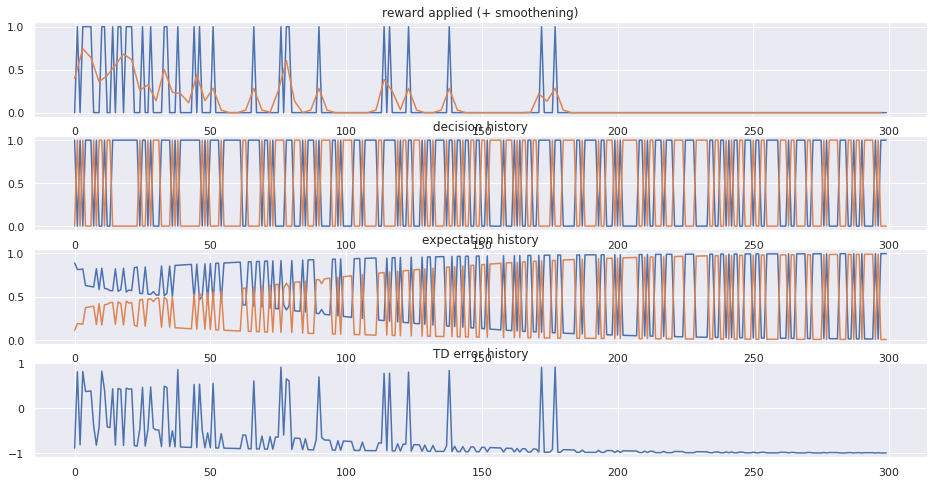

In [10]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

In [11]:
# Reverse contingency.
r_hist, decision_hist, exp_hist = simple_experiment(
    I, T=1000, num_trials=300, net=net, contingency=I2A_2)

In [12]:
# Post-processing (reversal).

t_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), t_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

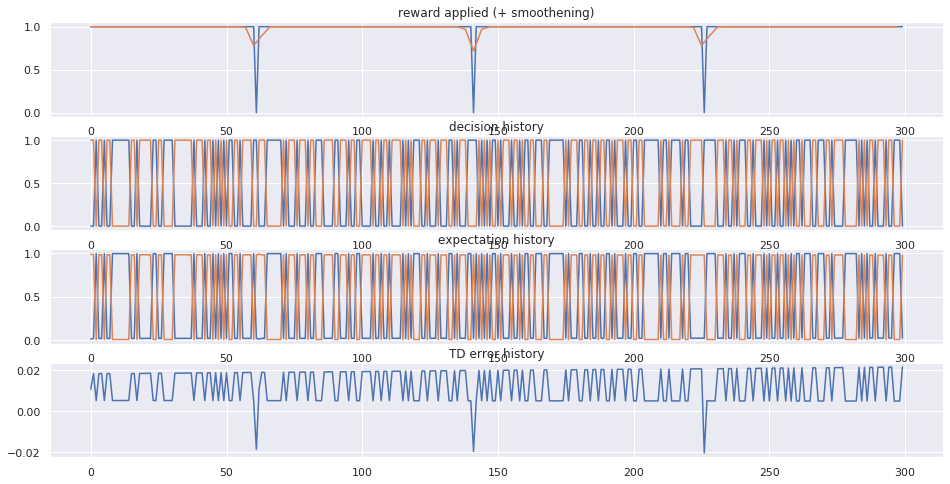

In [13]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(t_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()


## Qualms with the model

### Weight update
The experiments in the original paper lasted 100 trials.  I executed 300 trials in the first experiment in order to be able to observe any sort of convergence.  What is quickly very noticeable is that the model takes much longer than 100 trials to converge... with an accuracy of 0.  This is both good and bad; good because I just need to flip a sign, probably in the weight update, and it will be fixed.  It is bad because it would meant there is either a very unfortunate mistype in the publication or a very serious issue with their model.  The new equation now becomes:

\begin{align}
\Delta w_{out} = \eta (r - E[r]) (y_i - y_{th}) z_k \\
w_{out}(n + 1) = w_{out}(n) - \Delta w_{out} \\
\end{align}

I will keep the weight normalization as it was and run the initial learning experiment with 1000 trials in order to better observe convergence with this change:



In [14]:
class OFCPaperNeuralNetwork_v2(OFCPaperNeuralNetwork):
      def update_weights(self, r):
        row_vec = self.y - self.params['training threshold']
        col_vec = (r - self.exp_r) * self.z
        delta_w = self.params['learning rate'] * np.outer(row_vec, col_vec)
        self.output_weights -= delta_w
          

        # Normalize weights
        self.output_weights /= np.linalg.norm(self.output_weights)

In [15]:
# Initial learning experiment.

print("Learning rate = 0.001")
net = OFCPaperNeuralNetwork_v2(reservoir_network_params)

r_hist, decision_hist, exp_hist = simple_experiment(
    I, T=1000, num_trials=1000, net=net, contingency=I2A_1)

Learning rate = 0.001


In [16]:
# Post-processing.

# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

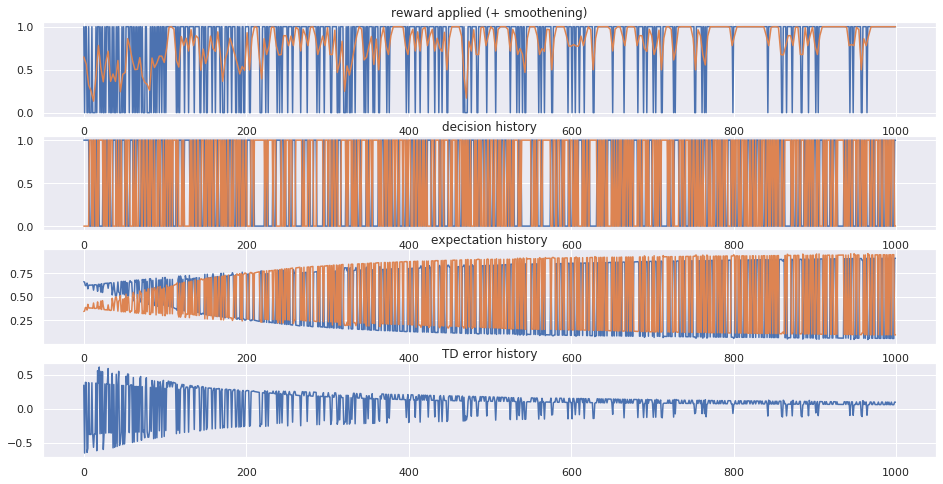

In [17]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

The model performs better as expected with the flipped sign in the weight update.  Now that the model is learning, it is possible to test the reversal learning.  It is worthy to note that, because the weights are being normalized at every update, any faster convergence in the second or further reversals is not due to the weight matrix's magnitude being closer to the new solution than the random initialization at the very beginning of the experiment.

In [18]:
# Reverse contingency.
r_hist, decision_hist, exp_hist = simple_experiment(
    I, T=1000, num_trials=1000, net=net, contingency=I2A_2)

In [19]:
# Post-processing (reversal).

t_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), t_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

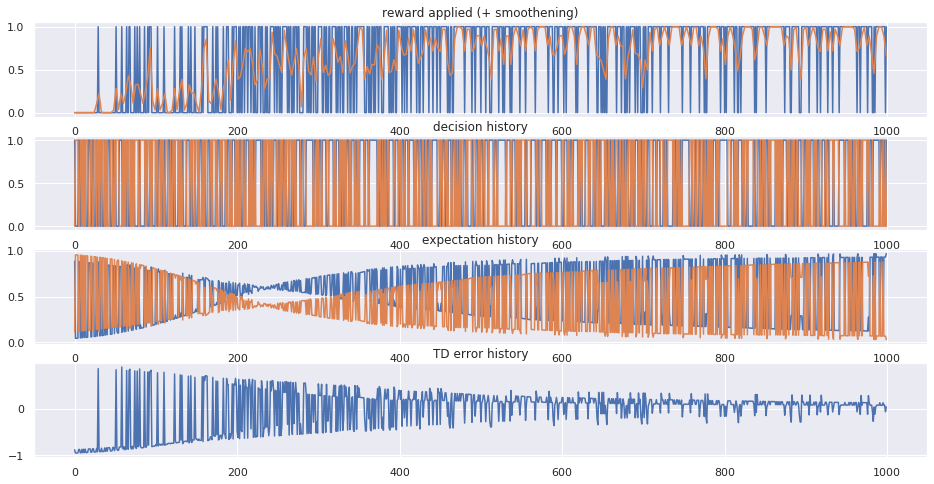

In [20]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

Here, it is very clear that the model is learning the new contingency.  However, it is noticeably slower than the initial learning, mostly due to the remaining trace of the previous learning task.  This is actually the observed learning behavior in **mice with OFC lesions**.  The authors of the paper stated that they could reproduce such behavior by removing the reward from the input given to the model, which means that a change in learning behaviour should be apparent if I also make this change.

### Reward Input
The initial motivation to attempt to recreate the results of this model was the fact that, as stated in the paper, the original reservoir model does not acquire the task structure (i.e. does not perform well), if the reward is not provided as input to the reservoir, also called here the State Encoding Layer (SEL). <br>

The justification for such a compromise is that the OFC does indeed eventually receive the reward perceived by the mouse and is crucial for it to learn the task structure.  However, the implementation of the trials, as explained in the paper, is that each new trial is presented with the reward from the previous trial.  This means the input being presented is, in fact, noisier, in a higher dimensional space, and not more predictive of the outcome of the present trial (than if it only had the texture as the input).<br>

I expect to see an improvement in the learning performance of the model without the previous reward being given along with the new texture input. 

In [21]:
class OFCPaperNeuralNetwork_v3(OFCPaperNeuralNetwork_v2):
    def __init__(self, params, nodes=500, input_dim=2, output_dim=2):
        super().__init__(params)
        self.init_input_weights(input_dim, nodes)


In [22]:
# Initial learning experiment.

print("Learning rate = 0.001")
net = OFCPaperNeuralNetwork_v3(reservoir_network_params)

r_hist, decision_hist, exp_hist = simple_experiment(
    I, T=1000, num_trials=1000, net=net, contingency=I2A_1,
    input_reward=False)

Learning rate = 0.001


In [23]:
# Post-processing.

# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

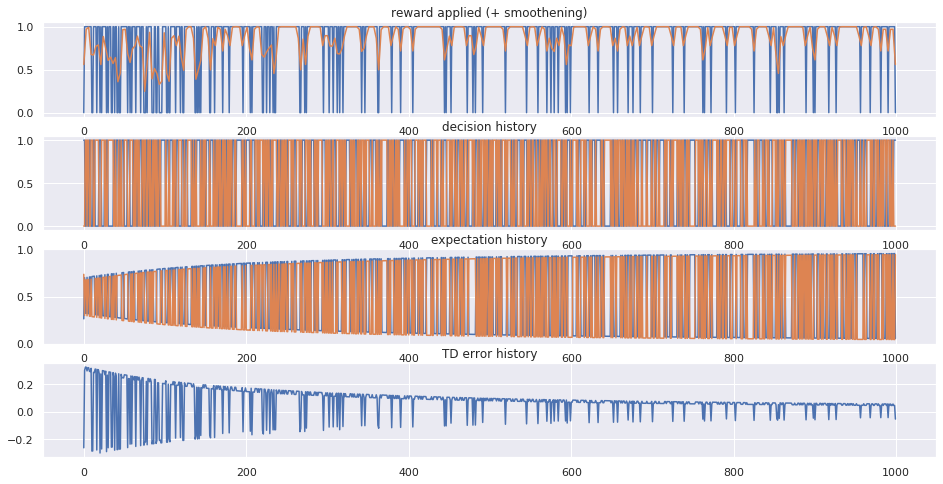

In [24]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

In [25]:
# Reverse contingency.
r_hist, decision_hist, exp_hist = simple_experiment(
    I, T=1000, num_trials=1000, net=net, contingency=I2A_2,
    input_reward=False)

In [26]:
# Post-processing (reversal).

t_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), t_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

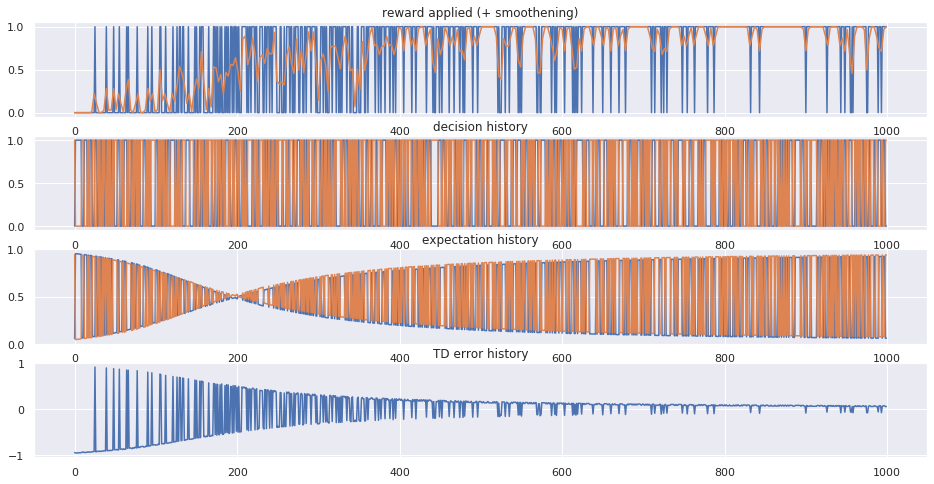

In [27]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

### Neuronal Decay
One of the fundamental aspects of reservoir networks is the memory that is preserved, with a certain decay, by the dynamical activity of its neurons; not by the neurons themselves.  In the parameters specified by the paper,  the $\tau=0.1$ of 100ms paired with a $dt=0.001$ of 1ms ensures that the decay of the effect of the input on the neurons is ruled by $x=\frac{x_0}{e}$ every 100ms.  Between the removal of the input and the application of the reward, there are exactly 200ms according to the experimental parameters; which means that the influence of the input will only have decayed by a factor of $\frac{x_0}{e^2}$.  <br>

In [28]:
# Experiment function.

def neuron_activation_trial(I, T=1000, net=None, contingency=None, 
                            input_reward=False):
    x_hist = []
    r = 0

    index = np.random.randint(I.shape[0])
    text_input = I[index]
    exp_output = contingency[index]

    decision = 0
    expectation = 0

    for ms in range(T):
        # Record mean activity of reservoir neurons.
        x_hist += [np.linalg.norm(net.x)]
        
        # Initial rest period (0 - 200ms) of trial
        if ms < (T * delay):
            net.step()
            continue

        # Apply input for the trial (200ms - 700ms)
        if 200 <= ms <= 700:
            if input_reward:
              net.step(np.append(text_input, r))
            else:
              net.step(text_input)
            continue

        # Measure output of the network (900ms)
        if ms == 900:
            net.step()
            decision, expectation = net.get_output(exp=True)
            r = int(np.array_equal(decision, exp_output))
            net.receive_reward(r)
            continue
            
        # If nothing needs to happen, move forward a timestep.
        net.step()

    return x_hist

In [29]:
# Observe activation of reservoir during one trial.
net = OFCPaperNeuralNetwork_v3(reservoir_network_params)

x_hist = neuron_activation_trial(I, net=net, contingency=I2A_1,
                                 input_reward=False)


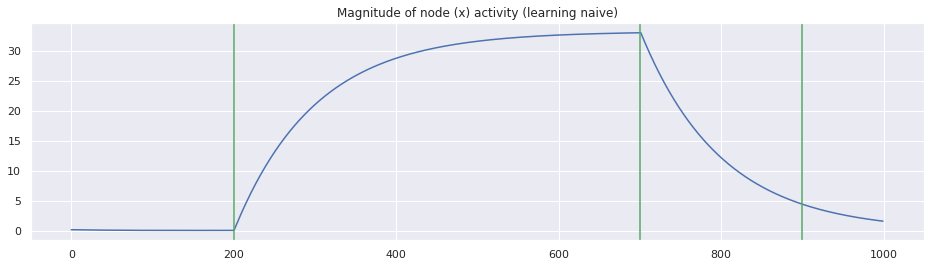

In [30]:
# Plot.
fig, ax = plt.subplots(nrows = 1, figsize=(4*4, 4))
vlines = [200, 700, 900]

ax.plot(x_hist)

ax.set_title("Magnitude of node (x) activity (learning naive)")

for x in vlines:
  plt.axvline(x=x, color='g')
plt.show()

The first green line in the graph denotes the timestep in which the input was first applied (200ms).  The input continued being applied until the second green line (700ms).  What follows is the exponential decay of the activation of the input in the reservoir nodes.  The third green line (900ms) denotes the location of where the model's decision is recorded and the rewarded is administered.  This is also the same timestep as the weight update.



In [31]:
#  Correlation test.
t_700 = np.array([x_hist[699]] * len(x_hist))
corr = np.correlate(t_700, x_hist, "same")

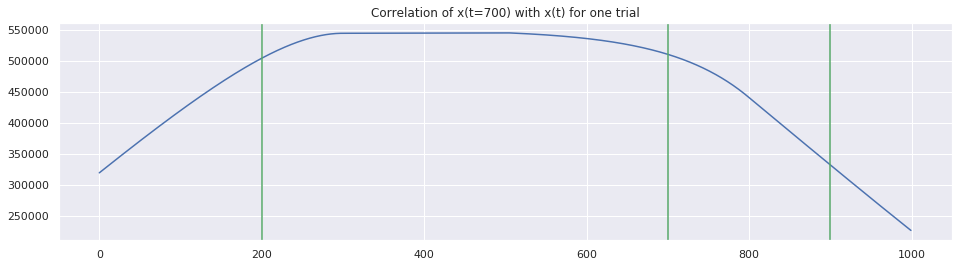

In [32]:
# Plot.
fig, ax = plt.subplots(nrows = 1, figsize=(4*4, 4))
vlines = [200, 700, 900]

ax.plot(corr)

ax.set_title("Correlation of x(t=700) with x(t) for one trial")

for x in vlines:
  plt.axvline(x=x, color='g')
plt.show()


The correlation graph further reinforces the point that the signal coming from the reservoir layer is still sufficiently correlated with the input in order for it to be a relatively easy task to train a predictor based on the input.  The dynamics of the reservoir are not responsible for any of the learning that is occuring in this experimental setup.  The dynamics of the reservoir need to be redesigned in order for it to truly exhibit an inherent memory capacity.

## Debugging the weight update equation

### Mathematics
The weight udpate equation used by Zhang, et. al. was previously published by Chi-Tat Law and Joshua I Gold in 2008 ([Reinforcement learning can account for associative and perceptual learning on a visual-decision task](http://europepmc.org/abstract/MED/19377473)).  I write below the original equation as well as Zhang, et. al.'s equation for reference:

Law & Gold:
\begin{align}
\Delta w_{out} = \alpha C(r - mE[r]) (x - nE[x]) \\
w_{out}(n + 1) = w_{out}(n) + \Delta w_{out} \\
\end{align}

Zhang et. al.:
\begin{align}
\Delta w_{out} = \eta (r - E[r]) (y_i - y_{th}) z_k \\
w_{out}(n + 1) = w_{out}(n) + \Delta w_{out} \\
\end{align}

In this case, $\alpha$ is the learning rate instead of $\eta$.  Both $m$ and $n$ are binary variables $[0,1]$ used to determine the use of the $E[-]$ parameters.  Much as in the Zhang et. al. equation, $(r - mE[r])$ represents the difference between the obtained reward and the confidence with which the prediction was made.  $x$ is the response of each neuron, while $E[x]$ is the baseline response, in direct correspondence with $(y - y_{th})$. 

The difference lies in the $C$ parameter, which can equal either $-1$ or $1$ according to the decision output by each neuron.  This then changed the direction of the weight update according to whether each neuron was correct or not.  In the case of $z_k$, it can only adopt values of either $0$ or $1$, which means that whenever a particular set of weights outputs a decision of 0, there will be no update regardless of whether it was correct or not.  Additionally, there is no change of sign in the final increment equation unless it comes from $(r - E[r])$.

### Reformulation
In order to test the change caused by the $C$ parameter in Law and Gold's equation, I will define a new variable $\zeta$:

\begin{align}
\zeta_k = (2z_k -1) \\
\Delta w_{out} = \eta \zeta_k(r - E[r]) (y_i - y_{th}) \\
w_{out}(n + 1) = w_{out}(n) + \Delta w_{out} \\
\end{align}

This will force $z_k$ to behave like the original $C$ parameter by mapping its values to either $-1$ or $1$.

In [33]:
class OFCPaperNeuralNetwork_v4(OFCPaperNeuralNetwork):
    def update_weights(self, r):
        zeta = 2*self.z - 1
        row_vec = self.y - self.params['training threshold']
        col_vec = (r - self.exp_r) * zeta
        delta_w = self.params['learning rate'] * np.outer(row_vec, col_vec)
        self.output_weights += delta_w

        # Normalize weights
        self.output_weights /= np.linalg.norm(self.output_weights)


In [34]:
# Initial learning experiment.

print("Learning rate = 0.001")
net = OFCPaperNeuralNetwork_v4(reservoir_network_params)

r_hist, decision_hist, exp_hist = simple_experiment(
    I, T=1000, num_trials=300, net=net, contingency=I2A_1)

Learning rate = 0.001


In [35]:
# Post-processing.

# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

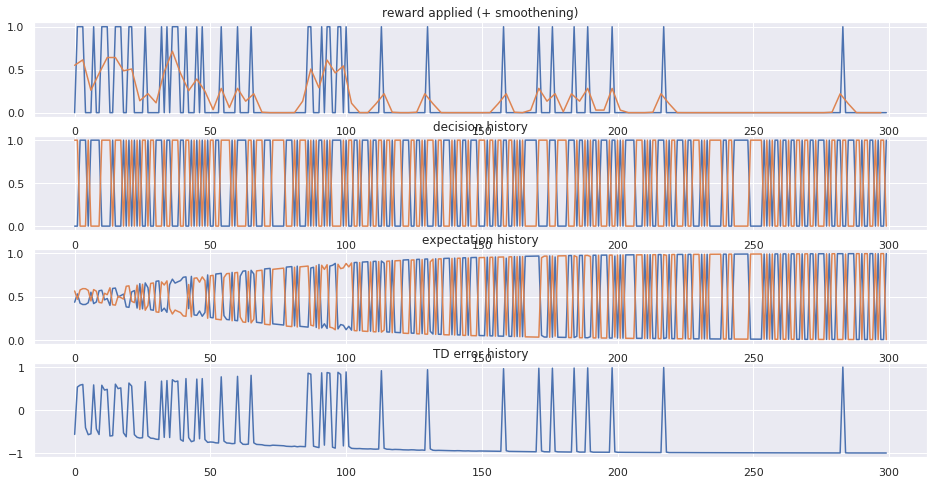

In [36]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

### Deeper inspection
It seems changing the update rule to reflect the previously published equation did not solve the problem.  This raises the suspicion that another part of the equation may be contributing an unexpected negative sign where it should not be.  Examining the parts individually:

- $\eta$ is a constant, positive quantity
- $\zeta$ is either $1$ or $-1$.  This should be the main source of any change of signs.
- $(r - E[r])$ in both publications has a lower bound of $0$ and an upper bound of $1$, so this quantity will always be positive
- $(y - y_{th})$ will need to be explored.  $y$ is constrained to always be positive, however, I have not yet explored what values this variable is producing.  The current threshold $y_{th}$ from the original paper is 0.2

I will proceed by mapping the mean magnitude of the neuron firing rates over the course of a single trial and compare this to the threshold being subtracted.

In [37]:
# Experiment function.

def neuron_firing_trial(I, T=1000, net=None, contingency=None, 
                            input_reward=False):
    y_mean = []
    y_norm = []
    r = 0

    index = np.random.randint(I.shape[0])
    text_input = I[index]
    exp_output = contingency[index]

    decision = 0
    expectation = 0

    for ms in range(T):
        # Record activity of reservoir neurons.
        y_mean += [np.mean(net.y)]
        y_norm += [np.linalg.norm(net.y)]
        
        # Initial rest period (0 - 200ms) of trial
        if ms < (T * delay):
            net.step()
            continue

        # Apply input for the trial (200ms - 700ms)
        if 200 <= ms <= 700:
            if input_reward:
              net.step(np.append(text_input, r))
            else:
              net.step(text_input)
            continue

        # Measure output of the network (900ms)
        if ms == 900:
            net.step()
            decision, expectation = net.get_output(exp=True)
            r = int(np.array_equal(decision, exp_output))
            net.receive_reward(r)
            continue
            
        # If nothing needs to happen, move forward a timestep.
        net.step()

    return y_mean, y_norm

In [38]:
# Observe activation of reservoir during one trial.
net = OFCPaperNeuralNetwork_v4(reservoir_network_params)

y_mean, y_norm = neuron_firing_trial(I, net=net,
                                         contingency=I2A_1,
                                         input_reward=True)


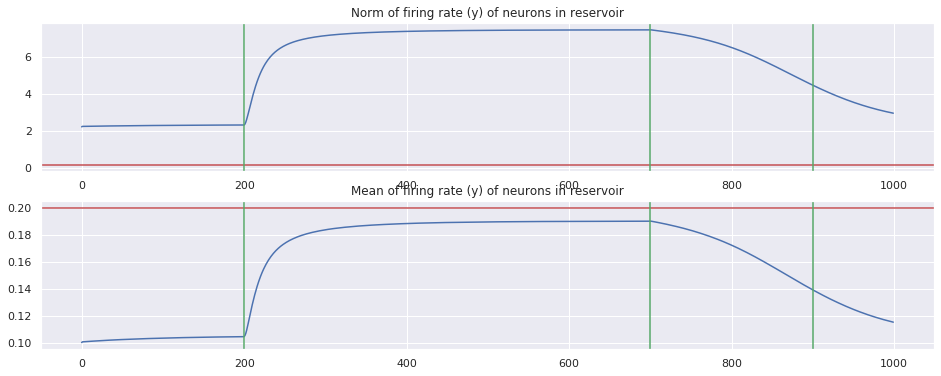

In [39]:
# Plot.
fig, ax = plt.subplots(nrows = 2, figsize=(4*4, 6))
vlines = [200, 700, 900]

y_th = net.params['training threshold']
ax[0].plot(y_norm)
ax[1].plot(y_mean)

ax[0].set_title("Norm of firing rate (y) of neurons in reservoir")
ax[1].set_title("Mean of firing rate (y) of neurons in reservoir")

for axis in ax:
  axis.axhline(y=y_th, color='r')
  for x in vlines:
    axis.axvline(x=x, color='g')
plt.show()


It seems that the function used to calculate the firing rate $y$ for each neuron is only producing very small values in spite of the large norm.  In order to dilucidate what may be happening, I will plot the last values of the reservoir network's firing rate.


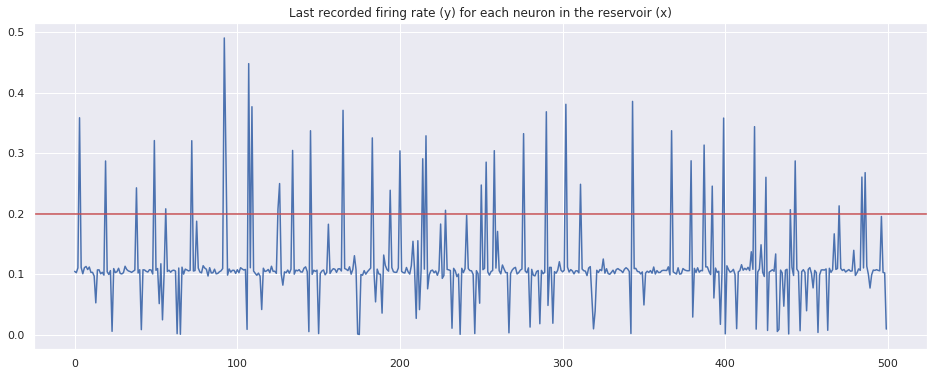

In [40]:
# Plot.
fig, ax = plt.subplots(nrows = 1, figsize=(4*4, 6))

ax.plot(net.y)

ax.set_title("Last recorded firing rate (y) for each neuron in the reservoir (x)")

ax.axhline(y=y_th, color='r')
plt.show()


The training threshold $y_{th}=0.2$ may be too large for the current values being produced.  Perhaps setting the threshold equal to the base firing rate $y_{th}=y_0=0.1$ or even $0$ will change the learning curve.

In [41]:
# Reservoir with y_th = y_0.
net = OFCPaperNeuralNetwork_v4(reservoir_network_params)
net.params['training threshold'] = reservoir_network_params['base firing rate']

r_hist, decision_hist, exp_hist = simple_experiment(
    I, T=1000, num_trials=300, net=net, contingency=I2A_1)

In [42]:
# Post-processing.

# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

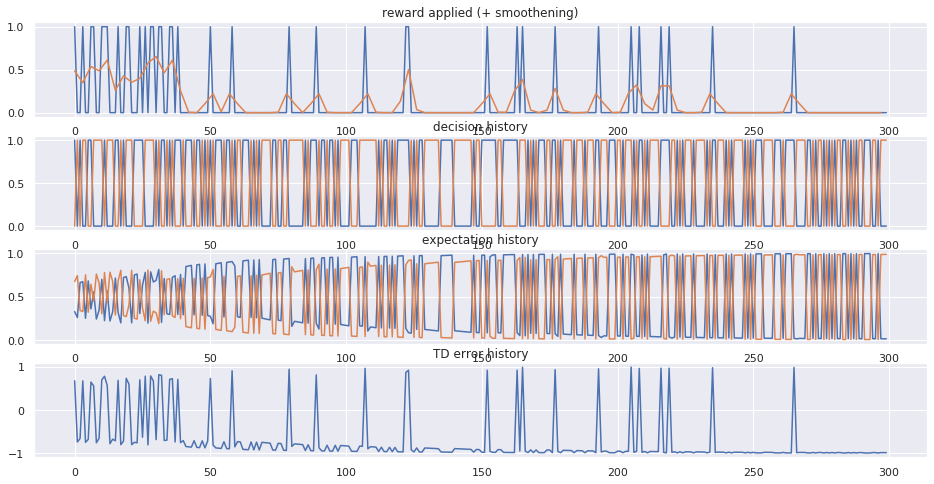

In [43]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

In [44]:
# Reservoir with y_th = 0.
net = OFCPaperNeuralNetwork_v4(reservoir_network_params)
net.params['training threshold'] = 0

r_hist, decision_hist, exp_hist = simple_experiment(
    I, T=1000, num_trials=300, net=net, contingency=I2A_1)

In [45]:
# Post-processing.

# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

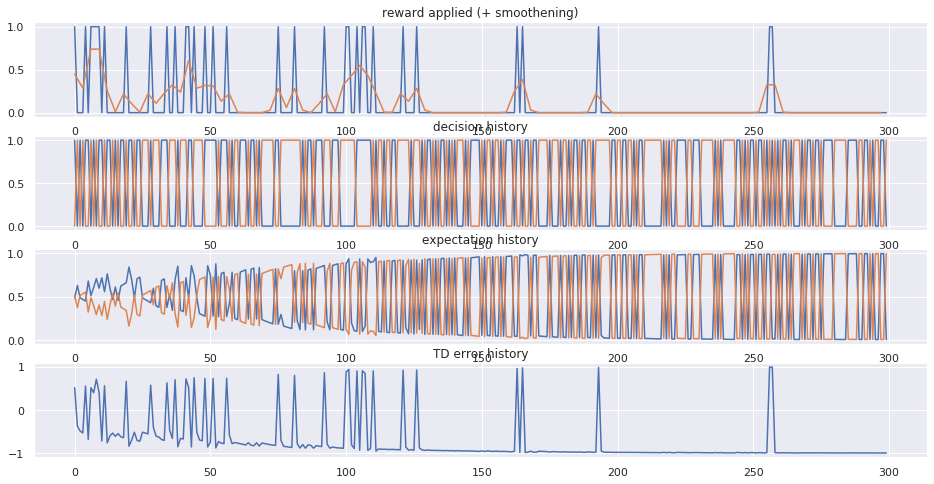

In [46]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

### The problem is not $\Delta w$
The more general equation and its corredsponding reformulation did not solve the sign issue.  This also is not an issue with the threshold firing rate $y_{th}$.  This leads me to think the problem does not lie in the weight update equation, but rather in how the `step()` function is being computed.

## Debugging the `step()` function
A closer inspection of the origina

### Implement a slow version of the weight update
When referencing [the original MATLAB code](https://github.com/tyangLab/ReservoirNet_OFC_TaskState) to determine whether my `step()` function had been implemented following their original mathematical formulations, I came accross [the following code (lines 60-66)](https://github.com/tyangLab/ReservoirNet_OFC_TaskState/blob/master/task1/actRNL.m):
```MATLAB
        %         v1 = weightSet.wDR1'*r_rec;
        %         v2 = weightSet.wDR2'*r_rec;
        pa = 1./(1+exp(network.delta*(v2-v1)));
        a = rand < pa;  %v1>v2;
        aind = 2-a;
        action = zeros(2,1);
        action(aind) = 1;
```

### Mathematics of the original code
Here I will explicitly write the equations being evaluated by the above code in their ```step()``` functions.  The calculation of $x$ and $y$ hare consistent with the equations presented and my code.

\begin{align}
\ \tau\frac{dx}{dt}= -x_i + g \sum_{j=1}^N w_{ij} y_j + w_i^{(i)}I + \sigma_{noise}dW_i \\
x(t + 1) = x(t) + \dot{x}(t)\Delta t
\end{align}

\begin{align}
y=   \left\{
\begin{array}{ll}
      y_0 + y_0 tanh(x/y_0) & x \leq 0   \\
      y_0 + (y_{max} - y_0)*tanh(\frac{x}{y_{max}- y_0}) & x > 0 \\
\end{array} 
\right.
\end{align}

There is, however, a divergence in the calculation of the final probabilites $p_k$ and expected reward $E[r]$:
\begin{align}
v_k = \sum_{i=1}^N w^{out}_{ik} * y_i \\
p = E[r] = \frac{1}{1 + e^{\beta (v_2 - v_1)}}
\end{align}

The equation they have implemented for the probability $p$ is a sigmoid of the difference between the 2 $v_k$.  This means that $p$ is now a scalar, with the expected reward being the 2D vector: $E[r]=[p, 1-p]$.  The chosen action $a_k$, is still a weighted random draw, and is represented by the binary 2D vector $z_k$, whose index encodes the chosen action.

### Reimplementation
I will now implement the newly formulated ```step()``` function as described by their code and observe the learning and reversal learning behavior.

In [47]:
# Reservoir network class with reformulated step() function.
# It is subclassed directly from the first OFCPaperNeuralNetwork
# class I implemented at the beginning of this notebook.
class OFCPaperNeuralNetwork_v5(OFCPaperNeuralNetwork):
       
    def step(self, I=0):
        if np.array_equal(I, 0):
            I = np.zeros(self.w_input.shape[0])

        tau = self.params['tau']
        dt = self.params['dt']
        g = self.params['network gain']
        sigma_noise = self.params['noise gain']
        y_0 = self.params['base firing rate']
        y_max = self.params['max firing rate']
        
        white_noise = np.random.randint(0, high=(1 + 1), size=self.x.size)
        
        dx_dt = 1/tau * (-self.x + g * np.dot(self.hidden_weights, self.y) 
                         + np.dot(self.w_input.T, I) 
                         + sigma_noise * white_noise)
        self.x += dx_dt * dt
        
        y_conditions =[self.x <= 0, self.x > 0]
        y_functions =[
            lambda x: y_0 + y_0 * np.tanh(x/y_0),
            lambda x: y_0 + (y_max - y_0) * np.tanh(x/(y_max - y_0))
        ]
        self.y = np.piecewise(self.x, y_conditions, y_functions)
        
        v = np.dot(self.y, self.output_weights)
        beta = self.params['temp parameter']
        p = 1/(1 + np.exp(beta*(v[1]-v[0])))
        #p = softmax(v[1] - v[0], beta)
        #print(p)
        
        a = np.random.uniform() < p
        a_idx = 1 - a
        
        self.z = np.zeros(2)
        self.z[a_idx] = 1
         
            
        self.exp_r = np.array([p, 1-p])
        return self.z


In [48]:
# Initial learning experiment.

print("Learning rate = 0.001")
net = OFCPaperNeuralNetwork_v5(reservoir_network_params)

r_hist, decision_hist, exp_hist = simple_experiment(
    I, T=1000, num_trials=1000, net=net, contingency=I2A_1)

Learning rate = 0.001


In [49]:
# Post-processing.

# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

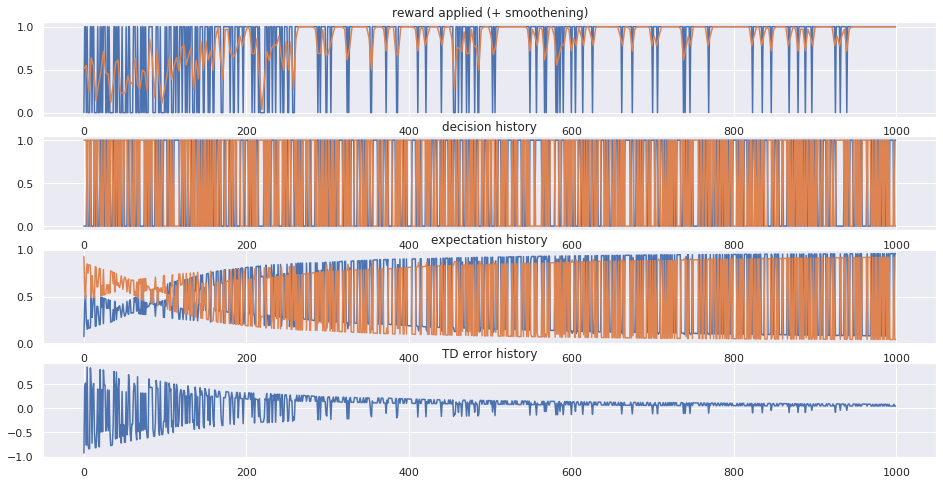

In [50]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

In [51]:
# Reversal learning.
r_hist, decision_hist, exp_hist = simple_experiment(
    I, T=1000, num_trials=1000, net=net, contingency=I2A_2)

In [52]:
# Post-processing.

# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

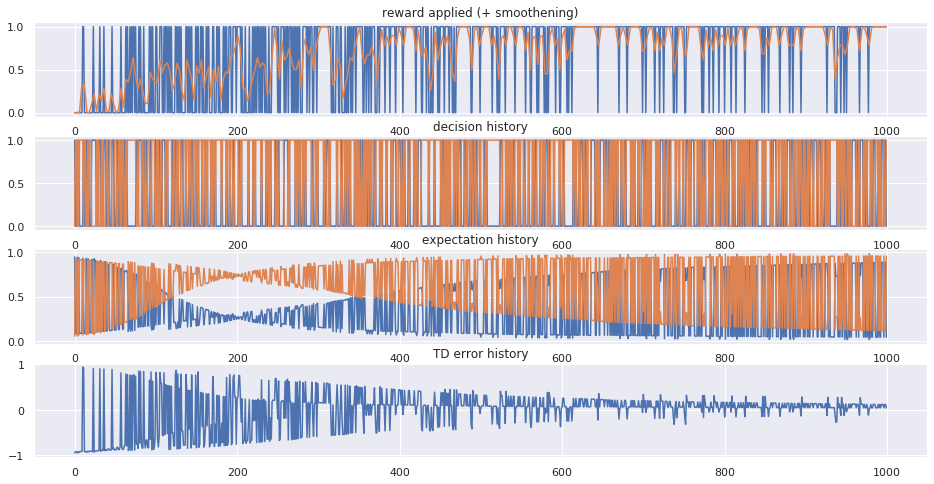

In [53]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

## Understanding the difference
I will now plot both the sigmoid function that is implemented in the original authors' code, as well as the softmax described in their written publication.

$$\sigma(\beta(v_2-v_1))$$
---

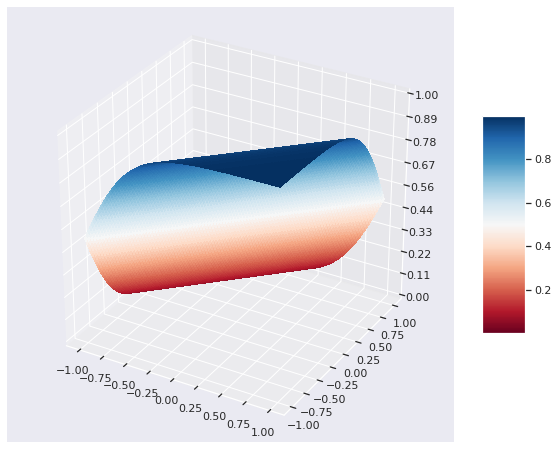

In [104]:
# Main axis variables.
v_1 = np.linspace(-1, 1, 100)
v_2 = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(v_1, v_2)

# Sample beta parameter.
beta = 1

# Wrapper sigmoid function (for plotting).
def multi_sigmoid(v_1, v_2, beta=4):
    x = beta*(v_2 - v_1)
    return sigmoid(x)

Z = multi_sigmoid(X, Y)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


\begin{align}
\frac{e^{-\beta v_k}}{\sum_i e^{-\beta v_i}}
\end{align}
---

In [ ]:
# Main axis variables.
v_1 = np.linspace(-1, 1, 100)
v_2 = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(v_1, v_2)

# Sample beta parameter.
beta = 1

# Wrapper sigmoid function (for plotting).
def multi_softmax(v_1, v_2, beta=4):
    x = np.vstack((v_1, v_2))
    print(x.shape)
    e = np.exp(-beta * x)
    return

Z = multi_softmax(v_1, v_2)
print(Z)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z[0], rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title('Softmax with respect to v_1')

fig.colorbar(surf, shrink=0.5, aspect=5)


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z[1], rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title('Softmax with respect to v_2')


plt.show()